In [1]:
import sys
sys.path.append('../src/gnn_tracking')
import torch
import numpy as np
from numpy.random import uniform
from torch_geometric.loader import DataLoader
from preprocessing.point_cloud_builder import PointCloudBuilder
from utils.plotting import GraphPlotter
from utils.plotting import EventPlotter
from utils.plotting import PointCloudPlotter
from models.track_condensation_networks import PointCloudTCN, GraphTCN
from training.graph_tcn_trainer import GraphTCNTrainer

/home/jdezoort/.conda/envs/pyg2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


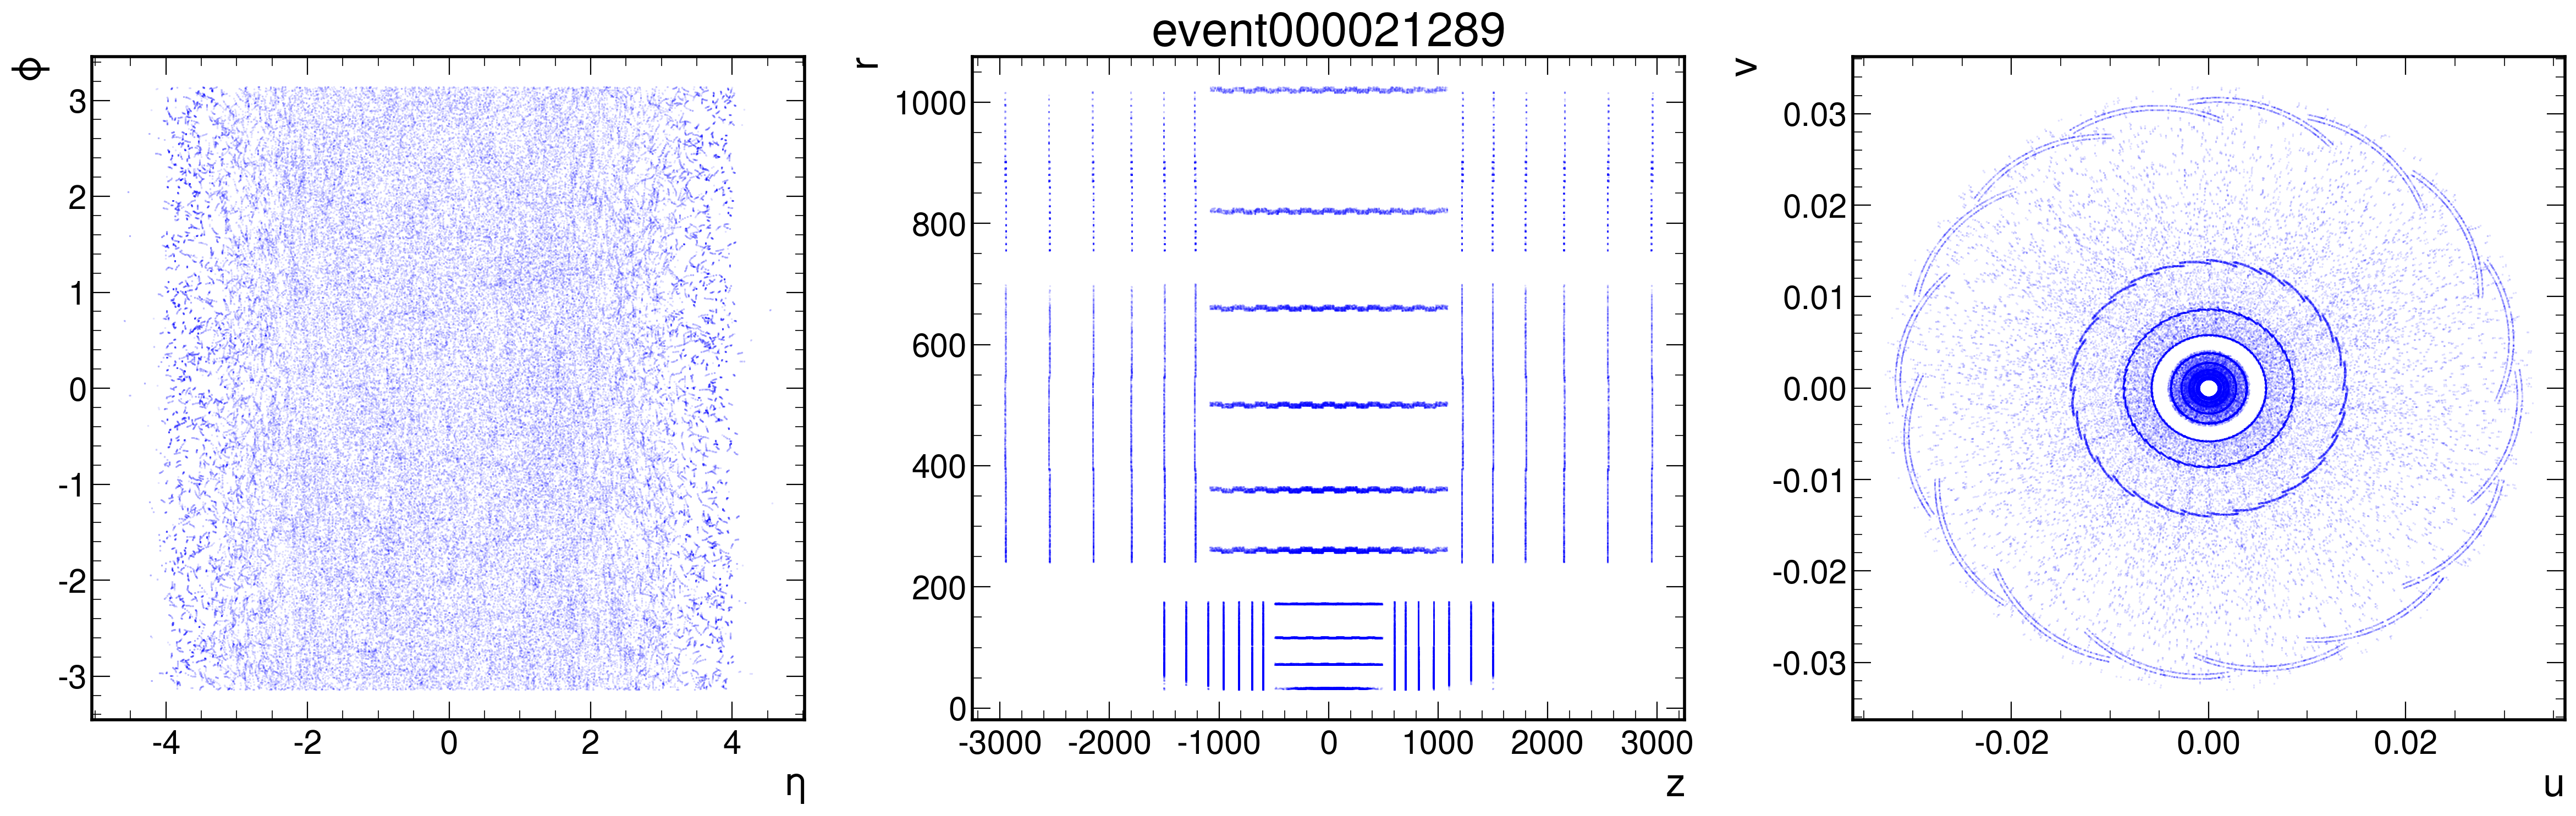

In [2]:
# we'll use n_evts * n_sectors = 640 graphs
n_evts, n_sectors = 10, 64
indir='/tigress/jdezoort/codalab/train_1'
event_plotter = EventPlotter(indir=indir)
event_plotter.plot_ep_rv_uv(evtid=21289)

In [3]:
# build point clouds for each sector in the pixel layers only
pc_builder = PointCloudBuilder(indir='/tigress/jdezoort/codalab/train_1', outdir='../point_clouds/',
                               n_sectors=n_sectors, pixel_only=True, redo=False, measurement_mode=False, thld=0.9)
pc_builder.process(n=10, verbose=False)

Processing /tigress/jdezoort/codalab/train_1/event000021289
Processing /tigress/jdezoort/codalab/train_1/event000021054
Processing /tigress/jdezoort/codalab/train_1/event000021371
Processing /tigress/jdezoort/codalab/train_1/event000021460
Processing /tigress/jdezoort/codalab/train_1/event000021612
Processing /tigress/jdezoort/codalab/train_1/event000021949
Processing /tigress/jdezoort/codalab/train_1/event000021853
Processing /tigress/jdezoort/codalab/train_1/event000021164
Processing /tigress/jdezoort/codalab/train_1/event000021475
Processing /tigress/jdezoort/codalab/train_1/event000021135
Output statistics: {'n_hits': 59611, 'n_particles': 8804, 'n_noise': 3688, 'n_sector_hits': 0, 'n_sector_particles': 0}


In [4]:
# each point cloud is a PyG Data object 
point_cloud = pc_builder.data_list[0]
point_cloud

Data(x=[1326, 6], layer=[1326], particle_id=[1326], pt=[1326], reconstructable=[1326], sector=[1326])

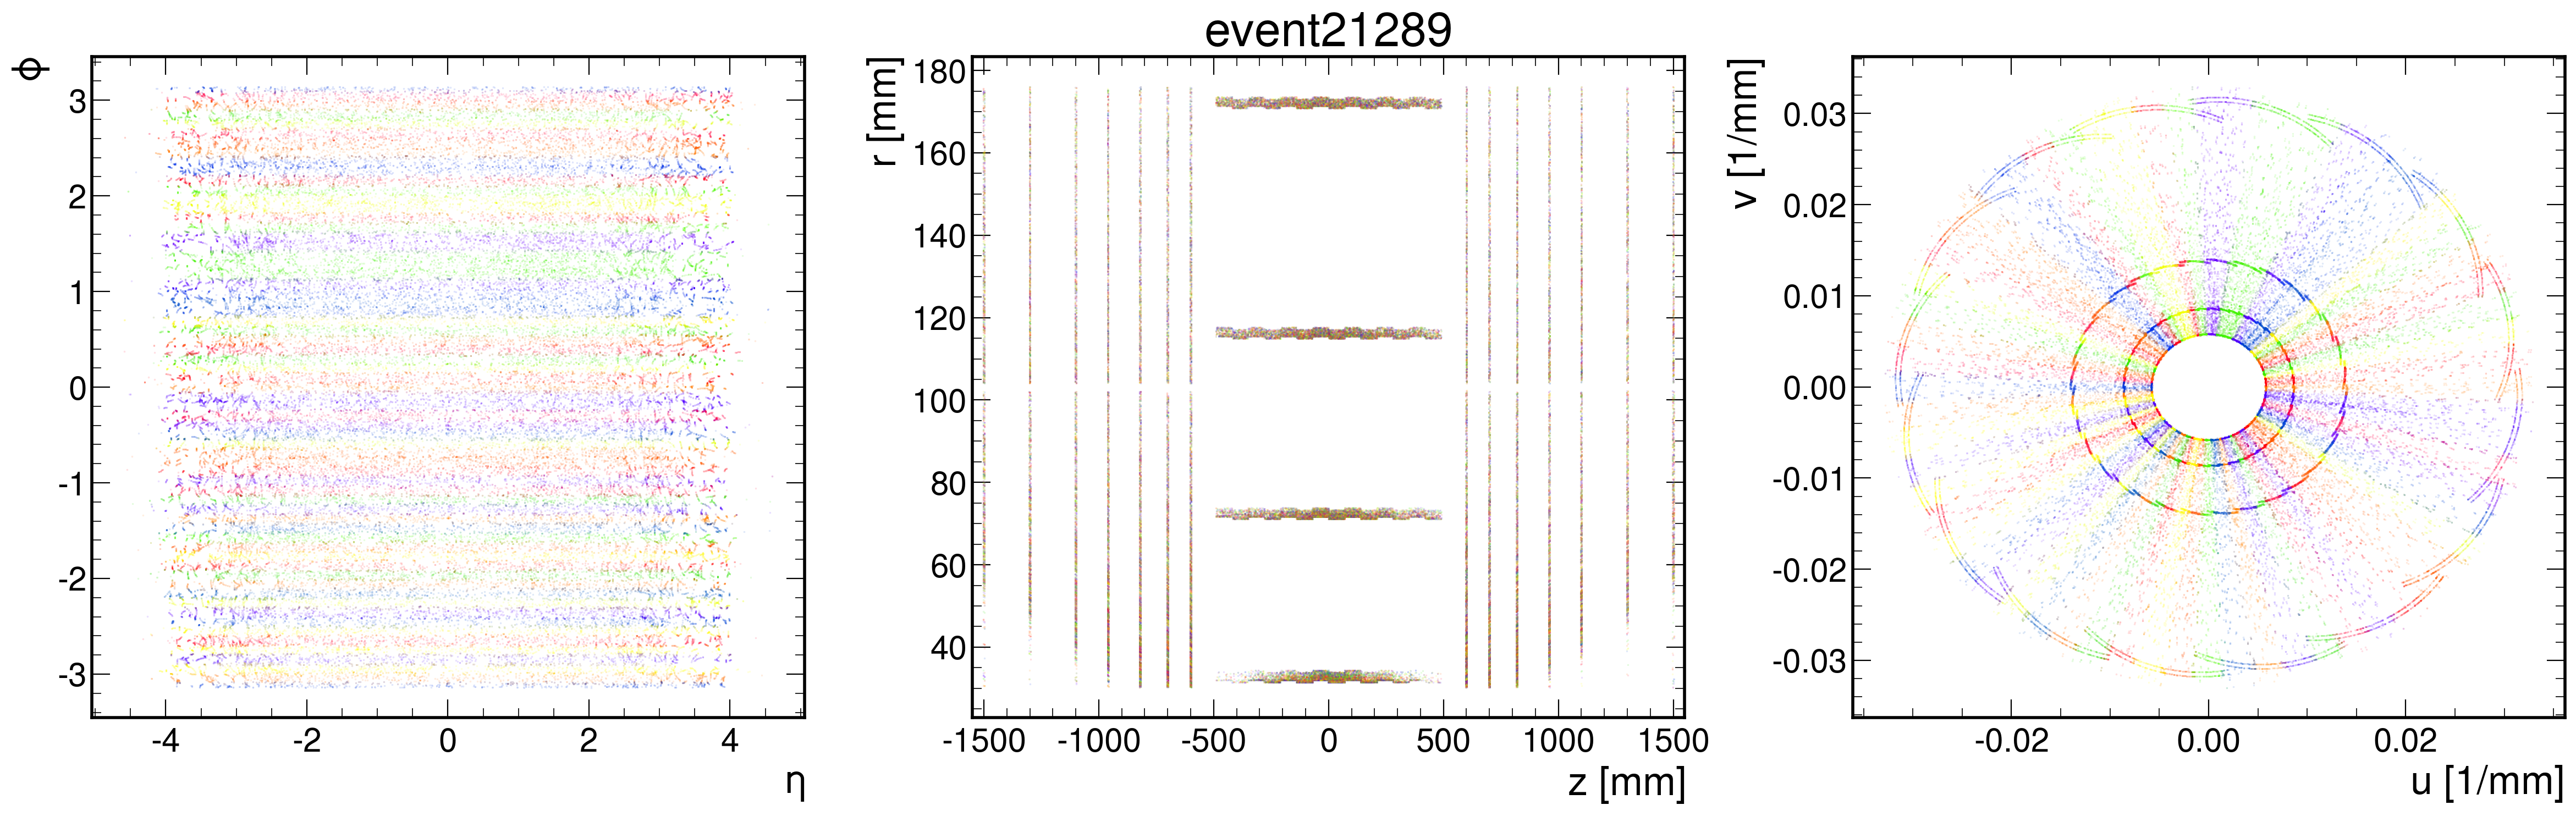

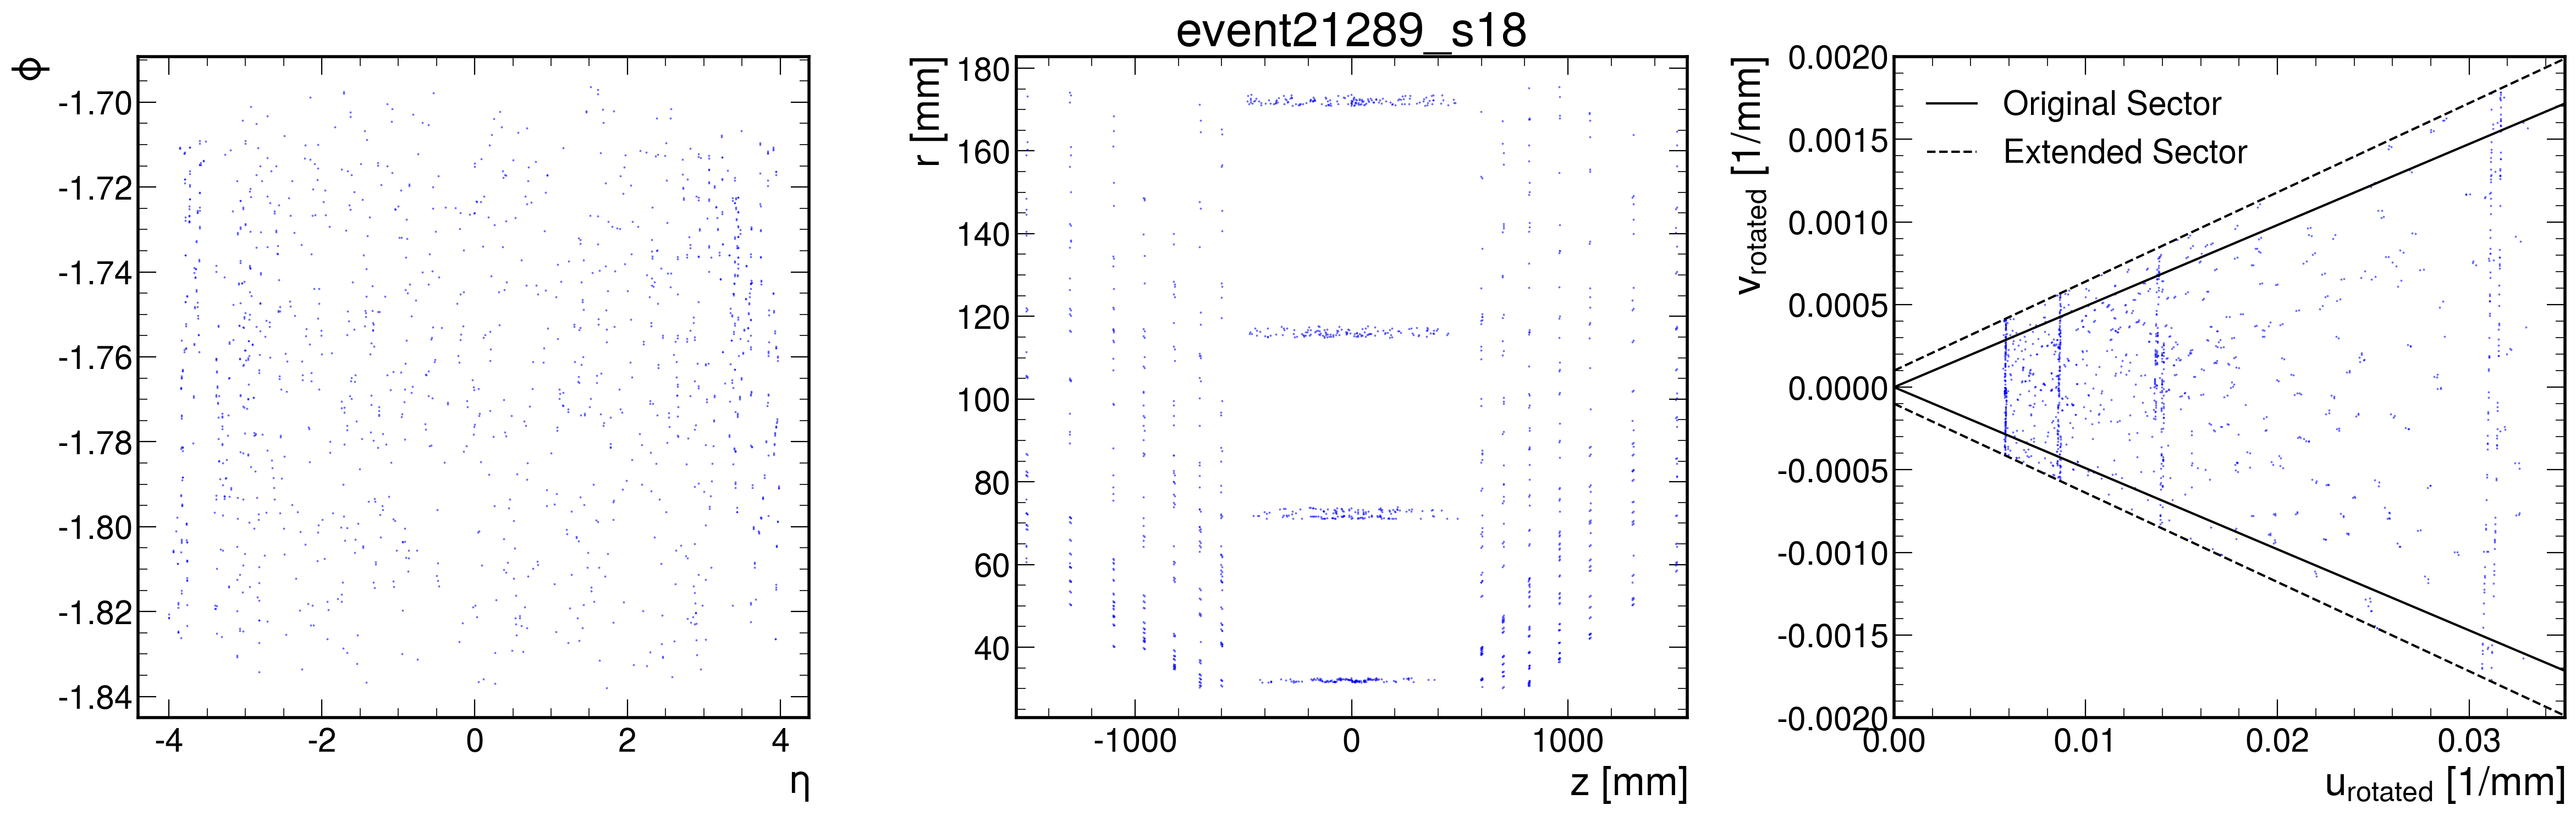

In [5]:
# visualize the sectors in each event and an overlapped ('extended') sector
pc_plotter = PointCloudPlotter('../point_clouds', 
                               n_sectors=pc_builder.n_sectors)
pc_plotter.plot_ep_rv_uv_all_sectors(21289)
pc_plotter.plot_ep_rv_uv_with_boundary(21289, 18, 
                                       pc_builder.sector_di,
                                       pc_builder.sector_ds)

In [6]:
# we can build graphs on the point clouds using geometric cuts

from graph_construction.graph_builder import GraphBuilder
graph_builder = GraphBuilder('../point_clouds/', '../graphs', redo=False)
graph_builder.process(verbose=False, n=n_evts*n_sectors)

In [7]:
# the graph plotter shows the true and false edges constructed by the builder

graph_plotter = GraphPlotter()
graph = graph_builder.data_list[0]
print(graph)
evtid, s = graph.evtid.item(), graph.s.item()

# takes a minute to run, but cool visual!
#graph_plotter.plot_rz(graph_builder.data_list[0], 
#          f'event{evtid}_s{s}')

Data(x=[1323, 6], edge_index=[2, 47918], edge_attr=[47918, 4], y=[47918], pt=[1323], particle_id=[1323], reconstructable=[1323], sector=[1323], evtid=[1], s=[1])


In [8]:
# use cuda (gpu) if possible, otherwise fallback to cpu
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f'Utilizing {device}')

# use reference graph to get relevant dimensions 
g = graph_builder.data_list[0]
node_indim = g.x.shape[1]
edge_indim = g.edge_attr.shape[1]
hc_outdim = 2 # output dim of latent space  

# partition graphs into train, test, val splits
graphs = graph_builder.data_list
n_graphs = len(graphs)
rand_array = uniform(low=0, high=1, size=n_graphs)
train_graphs = [g for i, g in enumerate(graphs) if (rand_array<=0.7)[i]]
test_graphs = [g for i, g in enumerate(graphs) if ((rand_array>0.7) & (rand_array<=0.9))[i]]
val_graphs = [g for i, g in enumerate(graphs) if (rand_array>0.9)[i]]

# build graph loaders
params = {'batch_size': 1, 'shuffle': True, 'num_workers': 2}
train_loader = DataLoader(list(train_graphs), **params)
params = {'batch_size': 1, 'shuffle': False, 'num_workers': 2}
test_loader = DataLoader(list(test_graphs), **params)
val_loader = DataLoader(list(val_graphs), **params)
loaders = {'train': train_loader, 'test': test_loader,
           'val': val_loader}
print('Loader sizes:', [(k, len(v)) for k, v in loaders.items()])

# set up a model and trainer
model = GraphTCN(node_indim, edge_indim, hc_outdim, hidden_dim=64)
trainer = GraphTCNTrainer(model=model, loaders=loaders)

Utilizing cuda
Loader sizes: [('train', 442), ('test', 140), ('val', 58)]


In [ ]:
import warnings
warnings.filterwarnings('ignore')
trainer.train()

---- Epoch 1 ----
Epoch 1 (0/442): loss=648.44141; loss_W=0.60775; loss_V=161.38174; loss_B=486.45193;
Epoch 1 (10/442): loss=505.16919; loss_W=0.61249; loss_V=45.92244; loss_B=458.63425;
Epoch 1 (20/442): loss=216.25218; loss_W=0.60753; loss_V=5.28900; loss_B=210.35565;
Epoch 1 (30/442): loss=106.43298; loss_W=0.56236; loss_V=0.86575; loss_B=105.00488;
Epoch 1 (40/442): loss=56.72231; loss_W=0.49636; loss_V=0.56794; loss_B=55.65801;
Epoch 1 (50/442): loss=28.45630; loss_W=0.39085; loss_V=1.71761; loss_B=26.34784;
Epoch 1 (60/442): loss=14.37063; loss_W=0.35075; loss_V=0.54362; loss_B=13.47626;
Epoch 1 (70/442): loss=8.45168; loss_W=0.33604; loss_V=0.46185; loss_B=7.65379;
Epoch 1 (80/442): loss=8.40275; loss_W=0.33886; loss_V=0.28352; loss_B=7.78038;
Epoch 1 (90/442): loss=9.33048; loss_W=0.35147; loss_V=0.14962; loss_B=8.82939;
Epoch 1 (100/442): loss=4.60906; loss_W=0.23909; loss_V=1.21928; loss_B=3.15069;
Epoch 1 (110/442): loss=4.45199; loss_W=0.32565; loss_V=0.12499; loss_B=4.001

Epoch 3 (70/442): loss=1.18521; loss_W=0.16088; loss_V=0.02167; loss_B=1.00267;
Epoch 3 (80/442): loss=1.15096; loss_W=0.13442; loss_V=0.01611; loss_B=1.00044;
Epoch 3 (90/442): loss=1.19841; loss_W=0.17769; loss_V=0.01308; loss_B=1.00764;
Epoch 3 (100/442): loss=1.21094; loss_W=0.18985; loss_V=0.01966; loss_B=1.00144;
Epoch 3 (110/442): loss=1.22166; loss_W=0.13234; loss_V=0.08458; loss_B=1.00473;
Epoch 3 (120/442): loss=1.20688; loss_W=0.18154; loss_V=0.02118; loss_B=1.00416;
Epoch 3 (130/442): loss=1.20705; loss_W=0.18493; loss_V=0.02045; loss_B=1.00167;
Epoch 3 (140/442): loss=1.16409; loss_W=0.13719; loss_V=0.02403; loss_B=1.00287;
Epoch 3 (150/442): loss=1.15568; loss_W=0.12979; loss_V=0.01787; loss_B=1.00802;
Epoch 3 (160/442): loss=1.22173; loss_W=0.19742; loss_V=0.01766; loss_B=1.00665;
Epoch 3 (170/442): loss=1.19906; loss_W=0.18084; loss_V=0.01582; loss_B=1.00240;
Epoch 3 (180/442): loss=1.16828; loss_W=0.15144; loss_V=0.01407; loss_B=1.00278;
Epoch 3 (190/442): loss=1.16579

Epoch 5 (150/442): loss=1.15622; loss_W=0.14688; loss_V=0.00885; loss_B=1.00050;
Epoch 5 (160/442): loss=1.15734; loss_W=0.14830; loss_V=0.00856; loss_B=1.00048;
Epoch 5 (170/442): loss=1.12430; loss_W=0.11356; loss_V=0.01055; loss_B=1.00019;
Epoch 5 (180/442): loss=1.13384; loss_W=0.12467; loss_V=0.00881; loss_B=1.00037;
Epoch 5 (190/442): loss=1.15712; loss_W=0.14465; loss_V=0.01229; loss_B=1.00018;
Epoch 5 (200/442): loss=1.13140; loss_W=0.12370; loss_V=0.00746; loss_B=1.00023;
Epoch 5 (210/442): loss=1.18685; loss_W=0.17642; loss_V=0.00956; loss_B=1.00086;
Epoch 5 (220/442): loss=1.16210; loss_W=0.15278; loss_V=0.00917; loss_B=1.00016;
Epoch 5 (230/442): loss=1.16079; loss_W=0.15334; loss_V=0.00716; loss_B=1.00029;
Epoch 5 (240/442): loss=1.12000; loss_W=0.11074; loss_V=0.00811; loss_B=1.00115;
Epoch 5 (250/442): loss=1.14678; loss_W=0.13824; loss_V=0.00847; loss_B=1.00008;
Epoch 5 (260/442): loss=1.15142; loss_W=0.14039; loss_V=0.00976; loss_B=1.00126;
Epoch 5 (270/442): loss=1.14

Epoch 7 (230/442): loss=1.15683; loss_W=0.14978; loss_V=0.00701; loss_B=1.00004;
Epoch 7 (240/442): loss=1.16846; loss_W=0.16009; loss_V=0.00818; loss_B=1.00019;
Epoch 7 (250/442): loss=1.13069; loss_W=0.12403; loss_V=0.00662; loss_B=1.00003;
Epoch 7 (260/442): loss=1.13807; loss_W=0.13160; loss_V=0.00614; loss_B=1.00033;
Epoch 7 (270/442): loss=1.16545; loss_W=0.15743; loss_V=0.00766; loss_B=1.00036;
Epoch 7 (280/442): loss=1.12981; loss_W=0.12340; loss_V=0.00636; loss_B=1.00004;
Epoch 7 (290/442): loss=1.12294; loss_W=0.11503; loss_V=0.00773; loss_B=1.00018;
Epoch 7 (300/442): loss=1.13239; loss_W=0.11735; loss_V=0.01461; loss_B=1.00043;
Epoch 7 (310/442): loss=1.14263; loss_W=0.13517; loss_V=0.00739; loss_B=1.00007;
Epoch 7 (320/442): loss=1.16720; loss_W=0.16181; loss_V=0.00530; loss_B=1.00008;
Epoch 7 (330/442): loss=1.15969; loss_W=0.15305; loss_V=0.00662; loss_B=1.00002;
Epoch 7 (340/442): loss=1.11899; loss_W=0.11210; loss_V=0.00682; loss_B=1.00007;
Epoch 7 (350/442): loss=1.14

Epoch 9 (310/442): loss=1.14489; loss_W=0.13917; loss_V=0.00570; loss_B=1.00002;
Epoch 9 (320/442): loss=1.13052; loss_W=0.12400; loss_V=0.00649; loss_B=1.00002;
Epoch 9 (330/442): loss=1.15125; loss_W=0.14526; loss_V=0.00578; loss_B=1.00021;
Epoch 9 (340/442): loss=1.13363; loss_W=0.12799; loss_V=0.00543; loss_B=1.00021;
Epoch 9 (350/442): loss=1.15076; loss_W=0.14442; loss_V=0.00632; loss_B=1.00002;
Epoch 9 (360/442): loss=1.13774; loss_W=0.13219; loss_V=0.00554; loss_B=1.00001;
Epoch 9 (370/442): loss=1.12556; loss_W=0.12055; loss_V=0.00501; loss_B=1.00001;
Epoch 9 (380/442): loss=1.11601; loss_W=0.10992; loss_V=0.00606; loss_B=1.00003;
Epoch 9 (390/442): loss=1.13718; loss_W=0.13193; loss_V=0.00524; loss_B=1.00001;
Epoch 9 (400/442): loss=1.14331; loss_W=0.13875; loss_V=0.00451; loss_B=1.00005;
Epoch 9 (410/442): loss=1.12092; loss_W=0.11566; loss_V=0.00524; loss_B=1.00002;
Epoch 9 (420/442): loss=1.13717; loss_W=0.13237; loss_V=0.00476; loss_B=1.00004;
Epoch 9 (430/442): loss=1.15

Epoch 11 (380/442): loss=1.12554; loss_W=0.12122; loss_V=0.00428; loss_B=1.00003;
Epoch 11 (390/442): loss=1.14797; loss_W=0.14269; loss_V=0.00527; loss_B=1.00001;
Epoch 11 (400/442): loss=1.14591; loss_W=0.14148; loss_V=0.00441; loss_B=1.00002;
Epoch 11 (410/442): loss=1.13882; loss_W=0.13461; loss_V=0.00420; loss_B=1.00001;
Epoch 11 (420/442): loss=1.14543; loss_W=0.14057; loss_V=0.00486; loss_B=1.00001;
Epoch 11 (430/442): loss=1.14050; loss_W=0.13607; loss_V=0.00441; loss_B=1.00002;
Epoch 11 (440/442): loss=1.10963; loss_W=0.10169; loss_V=0.00794; loss_B=1.00001;
test {'total': 1.1362696134119428, 'W': 0.13156559552465166, 'V': 0.004685178562067449, 'B': 1.0000188393252236, 'P': nan, 'acc': 0.8486819250243051}
---- Epoch 12 ----
Epoch 12 (0/442): loss=1.11375; loss_W=0.10746; loss_V=0.00628; loss_B=1.00001;
Epoch 12 (10/442): loss=1.11553; loss_W=0.11131; loss_V=0.00421; loss_B=1.00001;
Epoch 12 (20/442): loss=1.13175; loss_W=0.12767; loss_V=0.00408; loss_B=1.00000;
Epoch 12 (30/44

test {'total': 1.1349796698461951, 'W': 0.13090376337724072, 'V': 0.00406655450018921, 'B': 1.0000093519687652, 'P': nan, 'acc': 0.8501413302762167}
---- Epoch 14 ----
Epoch 14 (0/442): loss=1.12998; loss_W=0.12616; loss_V=0.00381; loss_B=1.00001;
Epoch 14 (10/442): loss=1.14314; loss_W=0.13985; loss_V=0.00326; loss_B=1.00004;
Epoch 14 (20/442): loss=1.14801; loss_W=0.14421; loss_V=0.00380; loss_B=1.00000;
Epoch 14 (30/442): loss=1.13834; loss_W=0.13443; loss_V=0.00389; loss_B=1.00001;
Epoch 14 (40/442): loss=1.11824; loss_W=0.11471; loss_V=0.00353; loss_B=1.00000;
Epoch 14 (50/442): loss=1.11761; loss_W=0.11326; loss_V=0.00434; loss_B=1.00001;
Epoch 14 (60/442): loss=1.14104; loss_W=0.13773; loss_V=0.00330; loss_B=1.00002;
Epoch 14 (70/442): loss=1.15664; loss_W=0.15247; loss_V=0.00415; loss_B=1.00002;
Epoch 14 (80/442): loss=1.13201; loss_W=0.12748; loss_V=0.00453; loss_B=1.00000;
Epoch 14 (90/442): loss=1.11935; loss_W=0.11354; loss_V=0.00578; loss_B=1.00003;
Epoch 14 (100/442): los

Epoch 16 (50/442): loss=1.13019; loss_W=0.12631; loss_V=0.00388; loss_B=1.00000;
Epoch 16 (60/442): loss=1.11676; loss_W=0.11334; loss_V=0.00341; loss_B=1.00001;
Epoch 16 (70/442): loss=1.13131; loss_W=0.12748; loss_V=0.00382; loss_B=1.00000;
Epoch 16 (80/442): loss=1.12963; loss_W=0.12640; loss_V=0.00323; loss_B=1.00000;
Epoch 16 (90/442): loss=1.15627; loss_W=0.15259; loss_V=0.00366; loss_B=1.00002;
Epoch 16 (100/442): loss=1.12253; loss_W=0.11892; loss_V=0.00361; loss_B=1.00001;
Epoch 16 (110/442): loss=1.14637; loss_W=0.14162; loss_V=0.00475; loss_B=1.00000;
Epoch 16 (120/442): loss=1.12716; loss_W=0.12271; loss_V=0.00445; loss_B=1.00000;
Epoch 16 (130/442): loss=1.14664; loss_W=0.14297; loss_V=0.00366; loss_B=1.00000;
Epoch 16 (140/442): loss=1.14092; loss_W=0.13687; loss_V=0.00404; loss_B=1.00000;
Epoch 16 (150/442): loss=1.12427; loss_W=0.12058; loss_V=0.00367; loss_B=1.00001;
Epoch 16 (160/442): loss=1.13157; loss_W=0.12770; loss_V=0.00385; loss_B=1.00002;
Epoch 16 (170/442): l

Epoch 18 (120/442): loss=1.10438; loss_W=0.09960; loss_V=0.00478; loss_B=1.00000;
Epoch 18 (130/442): loss=1.16124; loss_W=0.15753; loss_V=0.00371; loss_B=1.00000;
Epoch 18 (140/442): loss=1.14559; loss_W=0.14251; loss_V=0.00308; loss_B=1.00000;
Epoch 18 (150/442): loss=1.15741; loss_W=0.15428; loss_V=0.00312; loss_B=1.00001;
Epoch 18 (160/442): loss=1.17165; loss_W=0.16772; loss_V=0.00394; loss_B=1.00000;
Epoch 18 (170/442): loss=1.13487; loss_W=0.13204; loss_V=0.00283; loss_B=1.00000;
Epoch 18 (180/442): loss=1.15627; loss_W=0.15103; loss_V=0.00523; loss_B=1.00000;
Epoch 18 (190/442): loss=1.15239; loss_W=0.14896; loss_V=0.00342; loss_B=1.00001;
Epoch 18 (200/442): loss=1.14062; loss_W=0.13763; loss_V=0.00299; loss_B=1.00000;
Epoch 18 (210/442): loss=1.11644; loss_W=0.11280; loss_V=0.00364; loss_B=1.00000;
Epoch 18 (220/442): loss=1.13479; loss_W=0.13136; loss_V=0.00343; loss_B=1.00000;
Epoch 18 (230/442): loss=1.12965; loss_W=0.12456; loss_V=0.00509; loss_B=1.00000;
Epoch 18 (240/44

Epoch 20 (190/442): loss=1.11049; loss_W=0.10734; loss_V=0.00315; loss_B=1.00000;
Epoch 20 (200/442): loss=1.14486; loss_W=0.14172; loss_V=0.00314; loss_B=1.00000;
Epoch 20 (210/442): loss=1.12791; loss_W=0.12430; loss_V=0.00360; loss_B=1.00001;
Epoch 20 (220/442): loss=1.13488; loss_W=0.13163; loss_V=0.00324; loss_B=1.00001;
Epoch 20 (230/442): loss=1.11719; loss_W=0.11350; loss_V=0.00369; loss_B=1.00000;
Epoch 20 (240/442): loss=1.14802; loss_W=0.14522; loss_V=0.00279; loss_B=1.00001;
Epoch 20 (250/442): loss=1.12117; loss_W=0.11805; loss_V=0.00311; loss_B=1.00001;
Epoch 20 (260/442): loss=1.15842; loss_W=0.15529; loss_V=0.00313; loss_B=1.00001;
Epoch 20 (270/442): loss=1.14461; loss_W=0.14132; loss_V=0.00329; loss_B=1.00000;
Epoch 20 (280/442): loss=1.13687; loss_W=0.13379; loss_V=0.00306; loss_B=1.00002;
Epoch 20 (290/442): loss=1.13539; loss_W=0.13210; loss_V=0.00329; loss_B=1.00000;
Epoch 20 (300/442): loss=1.10906; loss_W=0.10607; loss_V=0.00298; loss_B=1.00001;
Epoch 20 (310/44

Epoch 22 (260/442): loss=1.13916; loss_W=0.13633; loss_V=0.00282; loss_B=1.00000;
Epoch 22 (270/442): loss=1.12831; loss_W=0.12452; loss_V=0.00379; loss_B=1.00000;
Epoch 22 (280/442): loss=1.12992; loss_W=0.12735; loss_V=0.00257; loss_B=1.00000;
Epoch 22 (290/442): loss=1.12701; loss_W=0.12394; loss_V=0.00307; loss_B=1.00000;
Epoch 22 (300/442): loss=1.11641; loss_W=0.11324; loss_V=0.00316; loss_B=1.00000;
Epoch 22 (310/442): loss=1.13910; loss_W=0.13587; loss_V=0.00323; loss_B=1.00000;
Epoch 22 (320/442): loss=1.11369; loss_W=0.11032; loss_V=0.00337; loss_B=1.00000;
Epoch 22 (330/442): loss=1.11747; loss_W=0.11452; loss_V=0.00295; loss_B=1.00000;
Epoch 22 (340/442): loss=1.13779; loss_W=0.13443; loss_V=0.00336; loss_B=1.00000;
Epoch 22 (350/442): loss=1.14819; loss_W=0.14533; loss_V=0.00286; loss_B=1.00000;
Epoch 22 (360/442): loss=1.13406; loss_W=0.13067; loss_V=0.00339; loss_B=1.00000;
Epoch 22 (370/442): loss=1.13406; loss_W=0.13127; loss_V=0.00279; loss_B=1.00000;
Epoch 22 (380/44

Epoch 24 (330/442): loss=1.12861; loss_W=0.12554; loss_V=0.00306; loss_B=1.00000;
Epoch 24 (340/442): loss=1.12647; loss_W=0.12376; loss_V=0.00271; loss_B=1.00000;
Epoch 24 (350/442): loss=1.14682; loss_W=0.14351; loss_V=0.00331; loss_B=1.00000;
Epoch 24 (360/442): loss=1.12980; loss_W=0.12700; loss_V=0.00279; loss_B=1.00000;
Epoch 24 (370/442): loss=1.15124; loss_W=0.14849; loss_V=0.00274; loss_B=1.00001;
Epoch 24 (380/442): loss=1.16883; loss_W=0.16597; loss_V=0.00285; loss_B=1.00000;
Epoch 24 (390/442): loss=1.14629; loss_W=0.14331; loss_V=0.00298; loss_B=1.00000;
Epoch 24 (400/442): loss=1.11490; loss_W=0.11217; loss_V=0.00273; loss_B=1.00000;
Epoch 24 (410/442): loss=1.15747; loss_W=0.15463; loss_V=0.00284; loss_B=1.00000;
Epoch 24 (420/442): loss=1.12740; loss_W=0.12470; loss_V=0.00270; loss_B=1.00000;
Epoch 24 (430/442): loss=1.14455; loss_W=0.14169; loss_V=0.00286; loss_B=1.00000;
Epoch 24 (440/442): loss=1.12944; loss_W=0.12674; loss_V=0.00270; loss_B=1.00000;
test {'total': 1

Epoch 26 (400/442): loss=1.16658; loss_W=0.16370; loss_V=0.00289; loss_B=1.00000;
Epoch 26 (410/442): loss=1.13053; loss_W=0.12796; loss_V=0.00257; loss_B=1.00000;
Epoch 26 (420/442): loss=1.13435; loss_W=0.13178; loss_V=0.00256; loss_B=1.00000;
Epoch 26 (430/442): loss=1.11561; loss_W=0.11263; loss_V=0.00298; loss_B=1.00000;
Epoch 26 (440/442): loss=1.12892; loss_W=0.12616; loss_V=0.00276; loss_B=1.00000;
test {'total': 1.131923181001496, 'W': 0.1291543019137212, 'V': 0.002766904471042965, 'B': 1.000001974616732, 'P': nan, 'acc': 0.8466585325343269}
---- Epoch 27 ----
Epoch 27 (0/442): loss=1.12063; loss_W=0.11807; loss_V=0.00256; loss_B=1.00000;
Epoch 27 (10/442): loss=1.13238; loss_W=0.12966; loss_V=0.00271; loss_B=1.00000;
Epoch 27 (20/442): loss=1.14280; loss_W=0.14017; loss_V=0.00263; loss_B=1.00000;
Epoch 27 (30/442): loss=1.11606; loss_W=0.11319; loss_V=0.00287; loss_B=1.00000;
Epoch 27 (40/442): loss=1.12110; loss_W=0.11844; loss_V=0.00266; loss_B=1.00000;
Epoch 27 (50/442): l

Epoch 29 (0/442): loss=1.12048; loss_W=0.11757; loss_V=0.00291; loss_B=1.00000;
Epoch 29 (10/442): loss=1.11978; loss_W=0.11732; loss_V=0.00246; loss_B=1.00000;
Epoch 29 (20/442): loss=1.12212; loss_W=0.11951; loss_V=0.00260; loss_B=1.00000;
Epoch 29 (30/442): loss=1.12209; loss_W=0.11977; loss_V=0.00231; loss_B=1.00000;
Epoch 29 (40/442): loss=1.12460; loss_W=0.12206; loss_V=0.00254; loss_B=1.00000;
Epoch 29 (50/442): loss=1.13713; loss_W=0.13464; loss_V=0.00249; loss_B=1.00000;
Epoch 29 (60/442): loss=1.14358; loss_W=0.14110; loss_V=0.00248; loss_B=1.00000;
Epoch 29 (70/442): loss=1.11995; loss_W=0.11726; loss_V=0.00268; loss_B=1.00000;
Epoch 29 (80/442): loss=1.12758; loss_W=0.12533; loss_V=0.00225; loss_B=1.00000;
Epoch 29 (90/442): loss=1.12853; loss_W=0.12601; loss_V=0.00252; loss_B=1.00000;
Epoch 29 (100/442): loss=1.14294; loss_W=0.14026; loss_V=0.00268; loss_B=1.00000;
Epoch 29 (110/442): loss=1.12944; loss_W=0.12668; loss_V=0.00277; loss_B=1.00000;
Epoch 29 (120/442): loss=1.

Epoch 31 (70/442): loss=1.13342; loss_W=0.13122; loss_V=0.00220; loss_B=1.00000;
Epoch 31 (80/442): loss=1.12761; loss_W=0.12513; loss_V=0.00248; loss_B=1.00000;
Epoch 31 (90/442): loss=1.13847; loss_W=0.13589; loss_V=0.00258; loss_B=1.00000;
Epoch 31 (100/442): loss=1.13770; loss_W=0.13464; loss_V=0.00306; loss_B=1.00000;
Epoch 31 (110/442): loss=1.14973; loss_W=0.14737; loss_V=0.00236; loss_B=1.00000;
Epoch 31 (120/442): loss=1.12028; loss_W=0.11775; loss_V=0.00253; loss_B=1.00000;
Epoch 31 (130/442): loss=1.11598; loss_W=0.11361; loss_V=0.00237; loss_B=1.00000;
Epoch 31 (140/442): loss=1.12409; loss_W=0.12148; loss_V=0.00262; loss_B=1.00000;
Epoch 31 (150/442): loss=1.12889; loss_W=0.12574; loss_V=0.00314; loss_B=1.00000;
Epoch 31 (160/442): loss=1.10629; loss_W=0.10353; loss_V=0.00276; loss_B=1.00000;
Epoch 31 (170/442): loss=1.12949; loss_W=0.12708; loss_V=0.00241; loss_B=1.00000;
Epoch 31 (180/442): loss=1.12204; loss_W=0.11927; loss_V=0.00277; loss_B=1.00000;
Epoch 31 (190/442):

Epoch 33 (140/442): loss=1.12118; loss_W=0.11864; loss_V=0.00254; loss_B=1.00000;
Epoch 33 (150/442): loss=1.14723; loss_W=0.14495; loss_V=0.00227; loss_B=1.00000;
Epoch 33 (160/442): loss=1.11600; loss_W=0.11364; loss_V=0.00236; loss_B=1.00000;
Epoch 33 (170/442): loss=1.11851; loss_W=0.11609; loss_V=0.00242; loss_B=1.00000;
Epoch 33 (180/442): loss=1.13930; loss_W=0.13702; loss_V=0.00227; loss_B=1.00000;
Epoch 33 (190/442): loss=1.12975; loss_W=0.12742; loss_V=0.00233; loss_B=1.00000;
Epoch 33 (200/442): loss=1.13446; loss_W=0.13223; loss_V=0.00223; loss_B=1.00000;
Epoch 33 (210/442): loss=1.15070; loss_W=0.14829; loss_V=0.00241; loss_B=1.00000;
Epoch 33 (220/442): loss=1.14642; loss_W=0.14412; loss_V=0.00230; loss_B=1.00000;
Epoch 33 (230/442): loss=1.10480; loss_W=0.10205; loss_V=0.00275; loss_B=1.00000;
Epoch 33 (240/442): loss=1.13872; loss_W=0.13645; loss_V=0.00227; loss_B=1.00000;
Epoch 33 (250/442): loss=1.11439; loss_W=0.11176; loss_V=0.00264; loss_B=1.00000;
Epoch 33 (260/44

Epoch 35 (210/442): loss=1.14855; loss_W=0.14628; loss_V=0.00226; loss_B=1.00000;
Epoch 35 (220/442): loss=1.11424; loss_W=0.11200; loss_V=0.00224; loss_B=1.00000;
Epoch 35 (230/442): loss=1.16226; loss_W=0.16007; loss_V=0.00219; loss_B=1.00000;
Epoch 35 (240/442): loss=1.11933; loss_W=0.11721; loss_V=0.00212; loss_B=1.00000;
Epoch 35 (250/442): loss=1.13319; loss_W=0.13072; loss_V=0.00247; loss_B=1.00000;
Epoch 35 (260/442): loss=1.12066; loss_W=0.11840; loss_V=0.00226; loss_B=1.00000;
Epoch 35 (270/442): loss=1.11947; loss_W=0.11741; loss_V=0.00207; loss_B=1.00000;
Epoch 35 (280/442): loss=1.13193; loss_W=0.12963; loss_V=0.00230; loss_B=1.00000;
Epoch 35 (290/442): loss=1.12561; loss_W=0.12369; loss_V=0.00193; loss_B=1.00000;
Epoch 35 (300/442): loss=1.11269; loss_W=0.11041; loss_V=0.00228; loss_B=1.00000;
Epoch 35 (310/442): loss=1.12500; loss_W=0.12277; loss_V=0.00222; loss_B=1.00000;
Epoch 35 (320/442): loss=1.15582; loss_W=0.15364; loss_V=0.00218; loss_B=1.00000;
Epoch 35 (330/44

Epoch 37 (280/442): loss=1.12017; loss_W=0.11824; loss_V=0.00194; loss_B=1.00000;
Epoch 37 (290/442): loss=1.12627; loss_W=0.12390; loss_V=0.00237; loss_B=1.00000;
Epoch 37 (300/442): loss=1.11207; loss_W=0.10987; loss_V=0.00220; loss_B=1.00000;
Epoch 37 (310/442): loss=1.15447; loss_W=0.15227; loss_V=0.00220; loss_B=1.00000;
Epoch 37 (320/442): loss=1.13560; loss_W=0.13382; loss_V=0.00179; loss_B=1.00000;
Epoch 37 (330/442): loss=1.14471; loss_W=0.14248; loss_V=0.00224; loss_B=1.00000;
Epoch 37 (340/442): loss=1.12603; loss_W=0.12407; loss_V=0.00196; loss_B=1.00000;
Epoch 37 (350/442): loss=1.11075; loss_W=0.10857; loss_V=0.00219; loss_B=1.00000;
Epoch 37 (360/442): loss=1.12406; loss_W=0.12178; loss_V=0.00228; loss_B=1.00000;
Epoch 37 (370/442): loss=1.13636; loss_W=0.13439; loss_V=0.00197; loss_B=1.00000;
Epoch 37 (380/442): loss=1.14030; loss_W=0.13813; loss_V=0.00217; loss_B=1.00000;
Epoch 37 (390/442): loss=1.15328; loss_W=0.15134; loss_V=0.00193; loss_B=1.00000;
Epoch 37 (400/44

Epoch 39 (350/442): loss=1.14515; loss_W=0.14314; loss_V=0.00201; loss_B=1.00000;
Epoch 39 (360/442): loss=1.14513; loss_W=0.14294; loss_V=0.00219; loss_B=1.00000;
Epoch 39 (370/442): loss=1.14031; loss_W=0.13836; loss_V=0.00195; loss_B=1.00000;
Epoch 39 (380/442): loss=1.12470; loss_W=0.12277; loss_V=0.00193; loss_B=1.00000;
Epoch 39 (390/442): loss=1.12036; loss_W=0.11823; loss_V=0.00213; loss_B=1.00000;
Epoch 39 (400/442): loss=1.12777; loss_W=0.12544; loss_V=0.00233; loss_B=1.00000;
Epoch 39 (410/442): loss=1.12645; loss_W=0.12442; loss_V=0.00203; loss_B=1.00000;
Epoch 39 (420/442): loss=1.11254; loss_W=0.11027; loss_V=0.00226; loss_B=1.00000;
Epoch 39 (430/442): loss=1.12794; loss_W=0.12566; loss_V=0.00228; loss_B=1.00000;
Epoch 39 (440/442): loss=1.13013; loss_W=0.12806; loss_V=0.00207; loss_B=1.00000;
test {'total': 1.1300398157884566, 'W': 0.12794015418205942, 'V': 0.002099547506077215, 'B': 1.00000011410032, 'P': nan, 'acc': 0.8512534818478993}
---- Epoch 40 ----
Epoch 40 (0/4

Epoch 41 (420/442): loss=1.13733; loss_W=0.13551; loss_V=0.00183; loss_B=1.00000;
Epoch 41 (430/442): loss=1.11835; loss_W=0.11638; loss_V=0.00197; loss_B=1.00000;
Epoch 41 (440/442): loss=1.16874; loss_W=0.16683; loss_V=0.00191; loss_B=1.00000;
test {'total': 1.1295992251394118, 'W': 0.12764100256775107, 'V': 0.001958192769338244, 'B': 1.0000000298023224, 'P': nan, 'acc': 0.8494954317808151}
---- Epoch 42 ----
Epoch 42 (0/442): loss=1.15385; loss_W=0.15193; loss_V=0.00192; loss_B=1.00000;
Epoch 42 (10/442): loss=1.12574; loss_W=0.12368; loss_V=0.00206; loss_B=1.00000;
Epoch 42 (20/442): loss=1.15122; loss_W=0.14919; loss_V=0.00203; loss_B=1.00000;
Epoch 42 (30/442): loss=1.15143; loss_W=0.14945; loss_V=0.00199; loss_B=1.00000;
Epoch 42 (40/442): loss=1.12292; loss_W=0.12117; loss_V=0.00174; loss_B=1.00000;
Epoch 42 (50/442): loss=1.11717; loss_W=0.11497; loss_V=0.00220; loss_B=1.00000;
Epoch 42 (60/442): loss=1.13295; loss_W=0.13111; loss_V=0.00184; loss_B=1.00000;
Epoch 42 (70/442): 

Epoch 44 (20/442): loss=1.14368; loss_W=0.14195; loss_V=0.00173; loss_B=1.00000;
Epoch 44 (30/442): loss=1.11905; loss_W=0.11728; loss_V=0.00177; loss_B=1.00000;
Epoch 44 (40/442): loss=1.13678; loss_W=0.13504; loss_V=0.00174; loss_B=1.00000;
Epoch 44 (50/442): loss=1.13819; loss_W=0.13613; loss_V=0.00206; loss_B=1.00000;
Epoch 44 (60/442): loss=1.12604; loss_W=0.12410; loss_V=0.00195; loss_B=1.00000;
Epoch 44 (70/442): loss=1.12552; loss_W=0.12382; loss_V=0.00171; loss_B=1.00000;
Epoch 44 (80/442): loss=1.12556; loss_W=0.12344; loss_V=0.00212; loss_B=1.00000;
Epoch 44 (90/442): loss=1.11842; loss_W=0.11628; loss_V=0.00214; loss_B=1.00000;
Epoch 44 (100/442): loss=1.12002; loss_W=0.11840; loss_V=0.00162; loss_B=1.00000;
Epoch 44 (110/442): loss=1.11266; loss_W=0.11073; loss_V=0.00193; loss_B=1.00000;
Epoch 44 (120/442): loss=1.13618; loss_W=0.13448; loss_V=0.00170; loss_B=1.00000;
Epoch 44 (130/442): loss=1.10428; loss_W=0.10178; loss_V=0.00250; loss_B=1.00000;
Epoch 44 (140/442): loss

Epoch 46 (90/442): loss=1.10340; loss_W=0.10148; loss_V=0.00192; loss_B=1.00000;
Epoch 46 (100/442): loss=1.13436; loss_W=0.13257; loss_V=0.00179; loss_B=1.00000;
Epoch 46 (110/442): loss=1.13501; loss_W=0.13337; loss_V=0.00163; loss_B=1.00000;
Epoch 46 (120/442): loss=1.12761; loss_W=0.12578; loss_V=0.00183; loss_B=1.00000;
Epoch 46 (130/442): loss=1.12784; loss_W=0.12621; loss_V=0.00163; loss_B=1.00000;
Epoch 46 (140/442): loss=1.14251; loss_W=0.14081; loss_V=0.00170; loss_B=1.00000;
Epoch 46 (150/442): loss=1.11380; loss_W=0.11198; loss_V=0.00182; loss_B=1.00000;
Epoch 46 (160/442): loss=1.14339; loss_W=0.14180; loss_V=0.00159; loss_B=1.00000;
Epoch 46 (170/442): loss=1.15614; loss_W=0.15454; loss_V=0.00160; loss_B=1.00000;
Epoch 46 (180/442): loss=1.11095; loss_W=0.10908; loss_V=0.00187; loss_B=1.00000;
Epoch 46 (190/442): loss=1.12233; loss_W=0.12066; loss_V=0.00167; loss_B=1.00000;
Epoch 46 (200/442): loss=1.12399; loss_W=0.12210; loss_V=0.00189; loss_B=1.00000;
Epoch 46 (210/442

Epoch 48 (160/442): loss=1.14273; loss_W=0.14121; loss_V=0.00152; loss_B=1.00000;
Epoch 48 (170/442): loss=1.12888; loss_W=0.12680; loss_V=0.00208; loss_B=1.00000;
Epoch 48 (180/442): loss=1.12010; loss_W=0.11846; loss_V=0.00164; loss_B=1.00000;
Epoch 48 (190/442): loss=1.12982; loss_W=0.12842; loss_V=0.00140; loss_B=1.00000;
Epoch 48 (200/442): loss=1.10730; loss_W=0.10559; loss_V=0.00171; loss_B=1.00000;
Epoch 48 (210/442): loss=1.10588; loss_W=0.10405; loss_V=0.00183; loss_B=1.00000;
Epoch 48 (220/442): loss=1.13125; loss_W=0.12973; loss_V=0.00152; loss_B=1.00000;
Epoch 48 (230/442): loss=1.13162; loss_W=0.13004; loss_V=0.00158; loss_B=1.00000;
Epoch 48 (240/442): loss=1.13833; loss_W=0.13666; loss_V=0.00167; loss_B=1.00000;
Epoch 48 (250/442): loss=1.11947; loss_W=0.11789; loss_V=0.00157; loss_B=1.00000;
Epoch 48 (260/442): loss=1.13254; loss_W=0.13120; loss_V=0.00134; loss_B=1.00000;
Epoch 48 (270/442): loss=1.11791; loss_W=0.11634; loss_V=0.00157; loss_B=1.00000;
Epoch 48 (280/44

Epoch 50 (230/442): loss=1.13349; loss_W=0.13167; loss_V=0.00181; loss_B=1.00000;
Epoch 50 (240/442): loss=1.11907; loss_W=0.11730; loss_V=0.00177; loss_B=1.00000;
Epoch 50 (250/442): loss=1.13251; loss_W=0.13100; loss_V=0.00152; loss_B=1.00000;
Epoch 50 (260/442): loss=1.10953; loss_W=0.10791; loss_V=0.00162; loss_B=1.00000;
Epoch 50 (270/442): loss=1.11088; loss_W=0.10897; loss_V=0.00191; loss_B=1.00000;
Epoch 50 (280/442): loss=1.12618; loss_W=0.12488; loss_V=0.00130; loss_B=1.00000;
Epoch 50 (290/442): loss=1.11642; loss_W=0.11488; loss_V=0.00154; loss_B=1.00000;
Epoch 50 (300/442): loss=1.10633; loss_W=0.10475; loss_V=0.00158; loss_B=1.00000;
Epoch 50 (310/442): loss=1.09934; loss_W=0.09753; loss_V=0.00181; loss_B=1.00000;
Epoch 50 (320/442): loss=1.10870; loss_W=0.10691; loss_V=0.00178; loss_B=1.00000;
Epoch 50 (330/442): loss=1.13232; loss_W=0.13069; loss_V=0.00163; loss_B=1.00000;
Epoch 50 (340/442): loss=1.14348; loss_W=0.14186; loss_V=0.00162; loss_B=1.00000;
Epoch 50 (350/44

Epoch 52 (300/442): loss=1.12327; loss_W=0.12191; loss_V=0.00136; loss_B=1.00000;
Epoch 52 (310/442): loss=1.13982; loss_W=0.13805; loss_V=0.00177; loss_B=1.00000;
Epoch 52 (320/442): loss=1.10935; loss_W=0.10773; loss_V=0.00162; loss_B=1.00000;
Epoch 52 (330/442): loss=1.12685; loss_W=0.12542; loss_V=0.00143; loss_B=1.00000;
Epoch 52 (340/442): loss=1.13807; loss_W=0.13671; loss_V=0.00136; loss_B=1.00000;
Epoch 52 (350/442): loss=1.16145; loss_W=0.16008; loss_V=0.00137; loss_B=1.00000;
Epoch 52 (360/442): loss=1.10970; loss_W=0.10816; loss_V=0.00154; loss_B=1.00000;
Epoch 52 (370/442): loss=1.13691; loss_W=0.13530; loss_V=0.00162; loss_B=1.00000;
Epoch 52 (380/442): loss=1.14669; loss_W=0.14500; loss_V=0.00170; loss_B=1.00000;
Epoch 52 (390/442): loss=1.13015; loss_W=0.12848; loss_V=0.00167; loss_B=1.00000;
Epoch 52 (400/442): loss=1.12269; loss_W=0.12126; loss_V=0.00143; loss_B=1.00000;
Epoch 52 (410/442): loss=1.12571; loss_W=0.12418; loss_V=0.00153; loss_B=1.00000;
Epoch 52 (420/44

Epoch 54 (370/442): loss=1.15272; loss_W=0.15120; loss_V=0.00152; loss_B=1.00000;
Epoch 54 (380/442): loss=1.11789; loss_W=0.11613; loss_V=0.00176; loss_B=1.00000;
Epoch 54 (390/442): loss=1.13220; loss_W=0.13095; loss_V=0.00126; loss_B=1.00000;
Epoch 54 (400/442): loss=1.12251; loss_W=0.12107; loss_V=0.00143; loss_B=1.00000;
Epoch 54 (410/442): loss=1.11645; loss_W=0.11491; loss_V=0.00154; loss_B=1.00000;
Epoch 54 (420/442): loss=1.14217; loss_W=0.14077; loss_V=0.00140; loss_B=1.00000;
Epoch 54 (430/442): loss=1.17434; loss_W=0.17304; loss_V=0.00130; loss_B=1.00000;
Epoch 54 (440/442): loss=1.12980; loss_W=0.12854; loss_V=0.00125; loss_B=1.00000;
test {'total': 1.1281172910023347, 'W': 0.12666209457176072, 'V': 0.0014551938760892621, 'B': 1.0000000025544848, 'P': nan, 'acc': 0.8478916091578347}
---- Epoch 55 ----
Epoch 55 (0/442): loss=1.13096; loss_W=0.12960; loss_V=0.00136; loss_B=1.00000;
Epoch 55 (10/442): loss=1.10592; loss_W=0.10435; loss_V=0.00156; loss_B=1.00000;
Epoch 55 (20/

Epoch 56 (440/442): loss=1.11726; loss_W=0.11588; loss_V=0.00138; loss_B=1.00000;
test {'total': 1.1278622321044427, 'W': 0.12639994908656393, 'V': 0.0014621765810131494, 'B': 1.0000001064368658, 'P': nan, 'acc': 0.8485892385244369}
---- Epoch 57 ----
Epoch 57 (0/442): loss=1.15100; loss_W=0.14961; loss_V=0.00139; loss_B=1.00000;
Epoch 57 (10/442): loss=1.12686; loss_W=0.12545; loss_V=0.00141; loss_B=1.00000;
Epoch 57 (20/442): loss=1.10930; loss_W=0.10794; loss_V=0.00135; loss_B=1.00000;
Epoch 57 (30/442): loss=1.12634; loss_W=0.12497; loss_V=0.00137; loss_B=1.00000;
Epoch 57 (40/442): loss=1.12207; loss_W=0.12054; loss_V=0.00153; loss_B=1.00000;
Epoch 57 (50/442): loss=1.11306; loss_W=0.11144; loss_V=0.00162; loss_B=1.00000;
Epoch 57 (60/442): loss=1.12489; loss_W=0.12349; loss_V=0.00139; loss_B=1.00000;
Epoch 57 (70/442): loss=1.10498; loss_W=0.10342; loss_V=0.00157; loss_B=1.00000;
Epoch 57 (80/442): loss=1.14064; loss_W=0.13953; loss_V=0.00110; loss_B=1.00000;
Epoch 57 (90/442): l

Epoch 59 (40/442): loss=1.12906; loss_W=0.12781; loss_V=0.00126; loss_B=1.00000;
Epoch 59 (50/442): loss=1.12783; loss_W=0.12635; loss_V=0.00148; loss_B=1.00000;
Epoch 59 (60/442): loss=1.14320; loss_W=0.14187; loss_V=0.00134; loss_B=1.00000;
Epoch 59 (70/442): loss=1.13973; loss_W=0.13851; loss_V=0.00122; loss_B=1.00000;
Epoch 59 (80/442): loss=1.11825; loss_W=0.11655; loss_V=0.00170; loss_B=1.00000;
Epoch 59 (90/442): loss=1.10938; loss_W=0.10807; loss_V=0.00131; loss_B=1.00000;
Epoch 59 (100/442): loss=1.13314; loss_W=0.13170; loss_V=0.00144; loss_B=1.00000;
Epoch 59 (110/442): loss=1.15014; loss_W=0.14892; loss_V=0.00122; loss_B=1.00000;
Epoch 59 (120/442): loss=1.13153; loss_W=0.13016; loss_V=0.00138; loss_B=1.00000;
Epoch 59 (130/442): loss=1.12212; loss_W=0.12058; loss_V=0.00154; loss_B=1.00000;
Epoch 59 (140/442): loss=1.11632; loss_W=0.11491; loss_V=0.00142; loss_B=1.00000;
Epoch 59 (150/442): loss=1.14508; loss_W=0.14350; loss_V=0.00158; loss_B=1.00000;
Epoch 59 (160/442): lo

Epoch 61 (110/442): loss=1.13380; loss_W=0.13212; loss_V=0.00169; loss_B=1.00000;
Epoch 61 (120/442): loss=1.12940; loss_W=0.12778; loss_V=0.00161; loss_B=1.00000;
Epoch 61 (130/442): loss=1.12391; loss_W=0.12259; loss_V=0.00132; loss_B=1.00000;
Epoch 61 (140/442): loss=1.12476; loss_W=0.12356; loss_V=0.00120; loss_B=1.00000;
Epoch 61 (150/442): loss=1.12239; loss_W=0.12116; loss_V=0.00123; loss_B=1.00000;
Epoch 61 (160/442): loss=1.10184; loss_W=0.10038; loss_V=0.00146; loss_B=1.00000;
Epoch 61 (170/442): loss=1.11379; loss_W=0.11230; loss_V=0.00149; loss_B=1.00000;
Epoch 61 (180/442): loss=1.13486; loss_W=0.13365; loss_V=0.00122; loss_B=1.00000;
Epoch 61 (190/442): loss=1.12195; loss_W=0.12069; loss_V=0.00126; loss_B=1.00000;
Epoch 61 (200/442): loss=1.12601; loss_W=0.12456; loss_V=0.00145; loss_B=1.00000;
Epoch 61 (210/442): loss=1.13635; loss_W=0.13513; loss_V=0.00122; loss_B=1.00000;
Epoch 61 (220/442): loss=1.12199; loss_W=0.12040; loss_V=0.00160; loss_B=1.00000;
Epoch 61 (230/44

Epoch 63 (180/442): loss=1.12360; loss_W=0.12231; loss_V=0.00128; loss_B=1.00000;
Epoch 63 (190/442): loss=1.13979; loss_W=0.13856; loss_V=0.00123; loss_B=1.00000;
Epoch 63 (200/442): loss=1.13149; loss_W=0.13039; loss_V=0.00111; loss_B=1.00000;
Epoch 63 (210/442): loss=1.14938; loss_W=0.14755; loss_V=0.00183; loss_B=1.00000;
Epoch 63 (220/442): loss=1.10832; loss_W=0.10662; loss_V=0.00169; loss_B=1.00000;
Epoch 63 (230/442): loss=1.12612; loss_W=0.12486; loss_V=0.00126; loss_B=1.00000;
Epoch 63 (240/442): loss=1.13608; loss_W=0.13503; loss_V=0.00105; loss_B=1.00000;
Epoch 63 (250/442): loss=1.13365; loss_W=0.13223; loss_V=0.00143; loss_B=1.00000;
Epoch 63 (260/442): loss=1.14948; loss_W=0.14836; loss_V=0.00112; loss_B=1.00000;
Epoch 63 (270/442): loss=1.14653; loss_W=0.14536; loss_V=0.00118; loss_B=1.00000;
Epoch 63 (280/442): loss=1.11076; loss_W=0.10943; loss_V=0.00133; loss_B=1.00000;
Epoch 63 (290/442): loss=1.11647; loss_W=0.11503; loss_V=0.00144; loss_B=1.00000;
Epoch 63 (300/44

Epoch 65 (250/442): loss=1.12655; loss_W=0.12528; loss_V=0.00127; loss_B=1.00000;
Epoch 65 (260/442): loss=1.13090; loss_W=0.12962; loss_V=0.00129; loss_B=1.00000;
Epoch 65 (270/442): loss=1.10956; loss_W=0.10831; loss_V=0.00125; loss_B=1.00000;
Epoch 65 (280/442): loss=1.13206; loss_W=0.13090; loss_V=0.00116; loss_B=1.00000;
Epoch 65 (290/442): loss=1.14424; loss_W=0.14294; loss_V=0.00129; loss_B=1.00000;
Epoch 65 (300/442): loss=1.13726; loss_W=0.13612; loss_V=0.00114; loss_B=1.00000;
Epoch 65 (310/442): loss=1.12548; loss_W=0.12420; loss_V=0.00127; loss_B=1.00000;
Epoch 65 (320/442): loss=1.13035; loss_W=0.12922; loss_V=0.00112; loss_B=1.00000;
Epoch 65 (330/442): loss=1.10768; loss_W=0.10619; loss_V=0.00148; loss_B=1.00000;
Epoch 65 (340/442): loss=1.12564; loss_W=0.12449; loss_V=0.00114; loss_B=1.00000;
Epoch 65 (350/442): loss=1.12808; loss_W=0.12692; loss_V=0.00116; loss_B=1.00000;
Epoch 65 (360/442): loss=1.12374; loss_W=0.12236; loss_V=0.00138; loss_B=1.00000;
Epoch 65 (370/44

Epoch 67 (320/442): loss=1.11612; loss_W=0.11482; loss_V=0.00130; loss_B=1.00000;
Epoch 67 (330/442): loss=1.12872; loss_W=0.12766; loss_V=0.00106; loss_B=1.00000;
Epoch 67 (340/442): loss=1.13940; loss_W=0.13802; loss_V=0.00139; loss_B=1.00000;
Epoch 67 (350/442): loss=1.13127; loss_W=0.13007; loss_V=0.00120; loss_B=1.00000;
Epoch 67 (360/442): loss=1.11941; loss_W=0.11796; loss_V=0.00144; loss_B=1.00000;
Epoch 67 (370/442): loss=1.13123; loss_W=0.13017; loss_V=0.00106; loss_B=1.00000;
Epoch 67 (380/442): loss=1.12578; loss_W=0.12459; loss_V=0.00118; loss_B=1.00000;
Epoch 67 (390/442): loss=1.12660; loss_W=0.12531; loss_V=0.00129; loss_B=1.00000;
Epoch 67 (400/442): loss=1.12943; loss_W=0.12829; loss_V=0.00113; loss_B=1.00000;
Epoch 67 (410/442): loss=1.13301; loss_W=0.13180; loss_V=0.00121; loss_B=1.00000;
Epoch 67 (420/442): loss=1.11029; loss_W=0.10909; loss_V=0.00120; loss_B=1.00000;
Epoch 67 (430/442): loss=1.12344; loss_W=0.12221; loss_V=0.00123; loss_B=1.00000;
Epoch 67 (440/44

Epoch 69 (390/442): loss=1.11345; loss_W=0.11219; loss_V=0.00126; loss_B=1.00000;
Epoch 69 (400/442): loss=1.12598; loss_W=0.12487; loss_V=0.00111; loss_B=1.00000;
Epoch 69 (410/442): loss=1.14335; loss_W=0.14216; loss_V=0.00119; loss_B=1.00000;
Epoch 69 (420/442): loss=1.11039; loss_W=0.10900; loss_V=0.00139; loss_B=1.00000;
Epoch 69 (430/442): loss=1.12251; loss_W=0.12124; loss_V=0.00126; loss_B=1.00000;
Epoch 69 (440/442): loss=1.12122; loss_W=0.12025; loss_V=0.00097; loss_B=1.00000;
test {'total': 1.1275287709007638, 'W': 0.126296216994524, 'V': 0.0012325539062398353, 'B': 1.0, 'P': nan, 'acc': 0.8541120320558548}
---- Epoch 70 ----
Epoch 70 (0/442): loss=1.13679; loss_W=0.13578; loss_V=0.00101; loss_B=1.00000;
Epoch 70 (10/442): loss=1.13991; loss_W=0.13874; loss_V=0.00117; loss_B=1.00000;
Epoch 70 (20/442): loss=1.11414; loss_W=0.11306; loss_V=0.00108; loss_B=1.00000;
Epoch 70 (30/442): loss=1.11114; loss_W=0.10985; loss_V=0.00129; loss_B=1.00000;
Epoch 70 (40/442): loss=1.09751;

Epoch 72 (0/442): loss=1.13695; loss_W=0.13586; loss_V=0.00109; loss_B=1.00000;
Epoch 72 (10/442): loss=1.14428; loss_W=0.14310; loss_V=0.00119; loss_B=1.00000;
Epoch 72 (20/442): loss=1.13725; loss_W=0.13617; loss_V=0.00108; loss_B=1.00000;
Epoch 72 (30/442): loss=1.10828; loss_W=0.10679; loss_V=0.00149; loss_B=1.00000;
Epoch 72 (40/442): loss=1.16308; loss_W=0.16188; loss_V=0.00120; loss_B=1.00000;
Epoch 72 (50/442): loss=1.15376; loss_W=0.15252; loss_V=0.00123; loss_B=1.00000;
Epoch 72 (60/442): loss=1.13991; loss_W=0.13874; loss_V=0.00117; loss_B=1.00000;
Epoch 72 (70/442): loss=1.12532; loss_W=0.12417; loss_V=0.00115; loss_B=1.00000;
Epoch 72 (80/442): loss=1.12787; loss_W=0.12664; loss_V=0.00123; loss_B=1.00000;
Epoch 72 (90/442): loss=1.13106; loss_W=0.12997; loss_V=0.00109; loss_B=1.00000;
Epoch 72 (100/442): loss=1.10658; loss_W=0.10527; loss_V=0.00131; loss_B=1.00000;
Epoch 72 (110/442): loss=1.12934; loss_W=0.12823; loss_V=0.00110; loss_B=1.00000;
Epoch 72 (120/442): loss=1.

Epoch 74 (70/442): loss=1.13376; loss_W=0.13274; loss_V=0.00102; loss_B=1.00000;
Epoch 74 (80/442): loss=1.11056; loss_W=0.10939; loss_V=0.00117; loss_B=1.00000;
Epoch 74 (90/442): loss=1.15385; loss_W=0.15251; loss_V=0.00134; loss_B=1.00000;
Epoch 74 (100/442): loss=1.12857; loss_W=0.12722; loss_V=0.00135; loss_B=1.00000;
Epoch 74 (110/442): loss=1.12221; loss_W=0.12106; loss_V=0.00115; loss_B=1.00000;
Epoch 74 (120/442): loss=1.11539; loss_W=0.11423; loss_V=0.00116; loss_B=1.00000;
Epoch 74 (130/442): loss=1.16304; loss_W=0.16207; loss_V=0.00097; loss_B=1.00000;
Epoch 74 (140/442): loss=1.12597; loss_W=0.12460; loss_V=0.00138; loss_B=1.00000;
Epoch 74 (150/442): loss=1.12675; loss_W=0.12553; loss_V=0.00122; loss_B=1.00000;
Epoch 74 (160/442): loss=1.14179; loss_W=0.14079; loss_V=0.00099; loss_B=1.00000;
Epoch 74 (170/442): loss=1.09776; loss_W=0.09662; loss_V=0.00114; loss_B=1.00000;
Epoch 74 (180/442): loss=1.12210; loss_W=0.12079; loss_V=0.00131; loss_B=1.00000;
Epoch 74 (190/442):

Epoch 76 (140/442): loss=1.11790; loss_W=0.11671; loss_V=0.00118; loss_B=1.00000;
Epoch 76 (150/442): loss=1.13186; loss_W=0.13069; loss_V=0.00117; loss_B=1.00000;
Epoch 76 (160/442): loss=1.11779; loss_W=0.11673; loss_V=0.00106; loss_B=1.00000;
Epoch 76 (170/442): loss=1.13073; loss_W=0.12953; loss_V=0.00120; loss_B=1.00000;
Epoch 76 (180/442): loss=1.11360; loss_W=0.11249; loss_V=0.00110; loss_B=1.00000;
Epoch 76 (190/442): loss=1.12186; loss_W=0.12074; loss_V=0.00112; loss_B=1.00000;
Epoch 76 (200/442): loss=1.14057; loss_W=0.13965; loss_V=0.00092; loss_B=1.00000;
Epoch 76 (210/442): loss=1.12507; loss_W=0.12401; loss_V=0.00105; loss_B=1.00000;
Epoch 76 (220/442): loss=1.12356; loss_W=0.12242; loss_V=0.00114; loss_B=1.00000;
Epoch 76 (230/442): loss=1.11402; loss_W=0.11276; loss_V=0.00126; loss_B=1.00000;
Epoch 76 (240/442): loss=1.14123; loss_W=0.14006; loss_V=0.00117; loss_B=1.00000;
Epoch 76 (250/442): loss=1.11180; loss_W=0.11015; loss_V=0.00165; loss_B=1.00000;
Epoch 76 (260/44

Epoch 78 (210/442): loss=1.10109; loss_W=0.09981; loss_V=0.00128; loss_B=1.00000;
Epoch 78 (220/442): loss=1.13003; loss_W=0.12886; loss_V=0.00117; loss_B=1.00000;
Epoch 78 (230/442): loss=1.13426; loss_W=0.13325; loss_V=0.00101; loss_B=1.00000;
Epoch 78 (240/442): loss=1.12704; loss_W=0.12596; loss_V=0.00109; loss_B=1.00000;
Epoch 78 (250/442): loss=1.17340; loss_W=0.17246; loss_V=0.00093; loss_B=1.00000;
Epoch 78 (260/442): loss=1.11140; loss_W=0.11021; loss_V=0.00119; loss_B=1.00000;
Epoch 78 (270/442): loss=1.12324; loss_W=0.12222; loss_V=0.00102; loss_B=1.00000;
Epoch 78 (280/442): loss=1.13249; loss_W=0.13108; loss_V=0.00142; loss_B=1.00000;
Epoch 78 (290/442): loss=1.13636; loss_W=0.13530; loss_V=0.00105; loss_B=1.00000;
Epoch 78 (300/442): loss=1.13414; loss_W=0.13292; loss_V=0.00122; loss_B=1.00000;
Epoch 78 (310/442): loss=1.14593; loss_W=0.14489; loss_V=0.00105; loss_B=1.00000;
Epoch 78 (320/442): loss=1.13328; loss_W=0.13217; loss_V=0.00111; loss_B=1.00000;
Epoch 78 (330/44

Epoch 80 (280/442): loss=1.13120; loss_W=0.13009; loss_V=0.00111; loss_B=1.00000;
Epoch 80 (290/442): loss=1.10539; loss_W=0.10414; loss_V=0.00125; loss_B=1.00000;
Epoch 80 (300/442): loss=1.14093; loss_W=0.13998; loss_V=0.00096; loss_B=1.00000;
Epoch 80 (310/442): loss=1.12771; loss_W=0.12653; loss_V=0.00118; loss_B=1.00000;
Epoch 80 (320/442): loss=1.10260; loss_W=0.10145; loss_V=0.00115; loss_B=1.00000;
Epoch 80 (330/442): loss=1.15756; loss_W=0.15638; loss_V=0.00118; loss_B=1.00000;
Epoch 80 (340/442): loss=1.11202; loss_W=0.11046; loss_V=0.00156; loss_B=1.00000;
Epoch 80 (350/442): loss=1.14512; loss_W=0.14389; loss_V=0.00123; loss_B=1.00000;
Epoch 80 (360/442): loss=1.10861; loss_W=0.10747; loss_V=0.00114; loss_B=1.00000;
Epoch 80 (370/442): loss=1.13046; loss_W=0.12932; loss_V=0.00114; loss_B=1.00000;
Epoch 80 (380/442): loss=1.14637; loss_W=0.14533; loss_V=0.00103; loss_B=1.00000;
Epoch 80 (390/442): loss=1.13031; loss_W=0.12923; loss_V=0.00108; loss_B=1.00000;
Epoch 80 (400/44

Epoch 82 (350/442): loss=1.16302; loss_W=0.16201; loss_V=0.00101; loss_B=1.00000;
Epoch 82 (360/442): loss=1.12102; loss_W=0.11966; loss_V=0.00135; loss_B=1.00000;
Epoch 82 (370/442): loss=1.11559; loss_W=0.11441; loss_V=0.00118; loss_B=1.00000;
Epoch 82 (380/442): loss=1.14282; loss_W=0.14158; loss_V=0.00124; loss_B=1.00000;
Epoch 82 (390/442): loss=1.10932; loss_W=0.10778; loss_V=0.00154; loss_B=1.00000;
Epoch 82 (400/442): loss=1.12459; loss_W=0.12339; loss_V=0.00120; loss_B=1.00000;
Epoch 82 (410/442): loss=1.11557; loss_W=0.11445; loss_V=0.00112; loss_B=1.00000;
Epoch 82 (420/442): loss=1.14573; loss_W=0.14473; loss_V=0.00100; loss_B=1.00000;
Epoch 82 (430/442): loss=1.12555; loss_W=0.12450; loss_V=0.00105; loss_B=1.00000;
Epoch 82 (440/442): loss=1.13815; loss_W=0.13689; loss_V=0.00127; loss_B=1.00000;
test {'total': 1.1273279608942435, 'W': 0.12615021717335498, 'V': 0.0011777437208885593, 'B': 1.0, 'P': nan, 'acc': 0.8596364068133491}
---- Epoch 83 ----
Epoch 83 (0/442): loss=1.

Epoch 84 (420/442): loss=1.11393; loss_W=0.11270; loss_V=0.00122; loss_B=1.00000;
Epoch 84 (430/442): loss=1.11406; loss_W=0.11282; loss_V=0.00124; loss_B=1.00000;
Epoch 84 (440/442): loss=1.13809; loss_W=0.13719; loss_V=0.00090; loss_B=1.00000;
test {'total': 1.1264979259709695, 'W': 0.12535529525152275, 'V': 0.0011426307194467103, 'B': 1.0, 'P': nan, 'acc': 0.8568473373140607}
---- Epoch 85 ----
Epoch 85 (0/442): loss=1.13390; loss_W=0.13297; loss_V=0.00094; loss_B=1.00000;
Epoch 85 (10/442): loss=1.12277; loss_W=0.12166; loss_V=0.00111; loss_B=1.00000;
Epoch 85 (20/442): loss=1.11401; loss_W=0.11294; loss_V=0.00106; loss_B=1.00000;
Epoch 85 (30/442): loss=1.11464; loss_W=0.11319; loss_V=0.00145; loss_B=1.00000;
Epoch 85 (40/442): loss=1.10968; loss_W=0.10864; loss_V=0.00103; loss_B=1.00000;
Epoch 85 (50/442): loss=1.10810; loss_W=0.10692; loss_V=0.00118; loss_B=1.00000;
Epoch 85 (60/442): loss=1.13047; loss_W=0.12913; loss_V=0.00134; loss_B=1.00000;
Epoch 85 (70/442): loss=1.10701; 

Epoch 87 (20/442): loss=1.12439; loss_W=0.12320; loss_V=0.00119; loss_B=1.00000;
Epoch 87 (30/442): loss=1.10296; loss_W=0.10127; loss_V=0.00169; loss_B=1.00000;
Epoch 87 (40/442): loss=1.13467; loss_W=0.13359; loss_V=0.00108; loss_B=1.00000;
Epoch 87 (50/442): loss=1.10628; loss_W=0.10499; loss_V=0.00129; loss_B=1.00000;
Epoch 87 (60/442): loss=1.11400; loss_W=0.11275; loss_V=0.00125; loss_B=1.00000;
Epoch 87 (70/442): loss=1.11967; loss_W=0.11847; loss_V=0.00120; loss_B=1.00000;
Epoch 87 (80/442): loss=1.11261; loss_W=0.11156; loss_V=0.00105; loss_B=1.00000;
Epoch 87 (90/442): loss=1.12936; loss_W=0.12814; loss_V=0.00122; loss_B=1.00000;
Epoch 87 (100/442): loss=1.14188; loss_W=0.14083; loss_V=0.00105; loss_B=1.00000;
Epoch 87 (110/442): loss=1.12371; loss_W=0.12263; loss_V=0.00107; loss_B=1.00000;
Epoch 87 (120/442): loss=1.13696; loss_W=0.13578; loss_V=0.00118; loss_B=1.00000;
Epoch 87 (130/442): loss=1.13950; loss_W=0.13838; loss_V=0.00112; loss_B=1.00000;
Epoch 87 (140/442): loss